In [7]:
import numpy as np

import random

import matplotlib.pyplot as plt 
from PIL import Image

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import learning_curve
from sklearn.neighbors import KNeighborsClassifier

import h5py

import time

import matplotlib.pyplot as plt 

from joblib import dump, load

import tensorflow as tf
#from tensorflow import keras
#from keras.datasets import mnist

import h5py

import numpy as np

from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
#from keras import backend as K



2022-03-26 18:47:09.377131: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-26 18:47:09.377165: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [17]:
def erreur_prediction(valeurs_predites= None, valeurs_reelle= None):
    """
    Vérifie que les valeurs prédites sont les mêmes que les valeurs réelles.
    
    paramètres en entrée:
    valeurs_predites
    valeurs_reelle
    
    Paramètres de sortie:
    erreur: nombre d'erreur de prédiction
    precision: 100*(1-erreur/(longueur des tableaux)
    liste_erreur: Liste de toutes les erreurs détecté sous forme de dictionnaire 
        clé valeur réelle: valeur prédite
    """
    
    assert len(valeurs_predites) == len(valeurs_reelle), "Erreur de dimension: la dimension des tableaux "+\
        f"doit être identique. {len(valeurs_predites)} # de {len(valeurs_reelle)}"

    erreur= 0
    d= {}
    longueur= len(valeurs_reelle)
    for i in range(longueur):
        if valeurs_reelle[i]!= valeurs_predites[i]:
            if valeurs_reelle[i] not in d.keys():
                d[valeurs_reelle[i]]= [valeurs_predites[i]]
            else:
                d[valeurs_reelle[i]].append(valeurs_predites[i])
            erreur+= 1
        
    return erreur, 100*(1-erreur/longueur), d

In [3]:
# On récupère les données et on les met en forme pour qu'elles soient compatible avec le CNN.
# la dimension des données de test et de train sont de type:
#  (shape[0],shape[1], shape[2]), il sera nécessaire d'y ajouter une dimension supplémentaire
data_train_pour_cnn= train_x.reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2], 1)
data_test_pour_cnn= test_x.reshape(test_x.shape[0], test_x.shape[1], test_x.shape[2], 1)

etiquette= np.unique(test_y)

# convert class vectors to binary class matrices
train_y_conv = keras.utils.to_categorical(train_y, len(etiquette))
test_y_conv = keras.utils.to_categorical(test_y, len(etiquette))


print(f"Entrainement: X Shape: {data_train_pour_cnn.shape}, Y shape: {train_y.shape}\n"+\
      f"Test: X Shape: {data_test_pour_cnn.shape}, Y shape: {test_y.shape}\n"+\
      f"Etiquette: {etiquette}")

Entrainement: X Shape: (60000, 28, 28, 1), Y shape: (60000,)
Test: X Shape: (10000, 28, 28, 1), Y shape: (10000,)
Etiquette: [0 1 2 3 4 5 6 7 8 9]


In [4]:
batch_size = 128
epochs = 10

input_shape= (train_x.shape[1], train_x.shape[2], 1)
nb_classe= len(etiquette)

model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3),activation='relu',input_shape= input_shape ))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(nb_classe, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.Adadelta(),metrics=['accuracy'])


2022-03-19 11:10:04.679796: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-19 11:10:04.679951: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-19 11:10:04.680043: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (debian-jpphi): /proc/driver/nvidia/version does not exist
2022-03-19 11:10:04.680999: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
checkpoint_path = "./cp-{epoch:04d}.ckpt"

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath= checkpoint_path, 
    verbose=1, 
    save_weights_only= True,
    save_freq=5*batch_size)


In [6]:
# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))


In [2]:
# Importation du jeux d'entraînement
f = h5py.File("./datas/train.hdf5", 'r')
train_x, train_y = (f['image'][...])/255.0, f['label'][...]
f.close()

# Importation du jeux de test
f = h5py.File("./datas/test.hdf5", 'r')
test_x, test_y = (f['image'][...])/255.0, f['label'][...]
f.close()



In [7]:
hist = model.fit(data_train_pour_cnn, train_y_conv, batch_size=batch_size, epochs=epochs, 
                 verbose=1,validation_data=(data_test_pour_cnn, test_y_conv), workers= -1, 
                 callbacks=[cp_callback])

#print("The model has successfully trained")
model.save(f'mnist_{epochs}')
#print("Saving the model as mnist.h5")
print("sauvegarde du modèle.")

2022-03-19 11:10:09.828401: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


Epoch 1/10
469/469 [==============================] - 232s 488ms/step - loss: 2.2750 - accuracy: 0.2069 - val_loss: 2.2347 - val_accuracy: 0.3213
Epoch 2/10
170/469 [=========>....................] - ETA: 2:27 - loss: 2.2294 - accuracy: 0.2993
Epoch 00002: saving model to ./cp-0002.ckpt
469/469 [==============================] - 252s 537ms/step - loss: 2.2061 - accuracy: 0.3327 - val_loss: 2.1583 - val_accuracy: 0.4233
Epoch 3/10
341/469 [====================>.........] - ETA: 59s - loss: 2.1390 - accuracy: 0.4147
Epoch 00003: saving model to ./cp-0003.ckpt
469/469 [==============================] - 229s 488ms/step - loss: 2.1261 - accuracy: 0.4275 - val_loss: 2.0640 - val_accuracy: 0.5431
Epoch 4/10
469/469 [==============================] - 264s 562ms/step - loss: 2.0237 - accuracy: 0.5120 - val_loss: 1.9410 - val_accuracy: 0.6245
Epoch 5/10
 43/469 [=>............................] - ETA: 3:45 - loss: 1.9545 - accuracy: 0.5489
Epoch 00005: saving model to ./cp-0005.ckpt
469/469 [====

2022-03-19 12:00:41.223404: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: mnist_10/assets
sauvegarde du modèle.


In [8]:
batch_size = 128
epochs = 10

input_shape= (train_x.shape[1], train_x.shape[2], 1)
nb_classe= len(etiquette)

model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3),activation='relu',input_shape= input_shape ))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(nb_classe, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.Adadelta(),metrics=['accuracy'])


In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 16)        160       
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 12, 12, 32)        0         
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               589952    
                                                      

In [12]:
latest = tf.train.latest_checkpoint("./")


model.load_weights(latest)

hist2 = model.fit(data_train_pour_cnn, train_y_conv, batch_size=batch_size, epochs=epochs, 
                 verbose=1,validation_data=(data_test_pour_cnn, test_y_conv), workers= -1)

#print("The model has successfully trained")
model.save(f'mnist_{epochs}')
#print("Saving the model as mnist.h5")
print("sauvegarde du modèle.")

2022-03-19 14:04:48.085056: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


Epoch 1/10
469/469 [==============================] - 299s 632ms/step - loss: 0.9731 - accuracy: 0.7505 - val_loss: 0.8189 - val_accuracy: 0.8251
Epoch 2/10
469/469 [==============================] - 504s 1s/step - loss: 0.8803 - accuracy: 0.7626 - val_loss: 0.7302 - val_accuracy: 0.8354
Epoch 3/10
469/469 [==============================] - 408s 870ms/step - loss: 0.8045 - accuracy: 0.7766 - val_loss: 0.6626 - val_accuracy: 0.8445
Epoch 4/10
469/469 [==============================] - 272s 579ms/step - loss: 0.7449 - accuracy: 0.7907 - val_loss: 0.6099 - val_accuracy: 0.8524
Epoch 5/10
469/469 [==============================] - 238s 507ms/step - loss: 0.6996 - accuracy: 0.7999 - val_loss: 0.5685 - val_accuracy: 0.8588
Epoch 6/10
469/469 [==============================] - 253s 539ms/step - loss: 0.6641 - accuracy: 0.8060 - val_loss: 0.5353 - val_accuracy: 0.8641
Epoch 7/10
469/469 [==============================] - 318s 679ms/step - loss: 0.6321 - accuracy: 0.8152 - val_loss: 0.5080 - va

In [13]:
model.save(f'mnist.h5')

In [15]:
epochs= 100
model = keras.models.load_model('mnist_101.h5')

hist3 = model.fit(data_train_pour_cnn, train_y_conv, batch_size=batch_size, epochs=epochs, 
                 verbose=1,validation_data=(data_test_pour_cnn, test_y_conv), workers= -1)

#print("The model has successfully trained")
model.save(f'mnist_{epochs}2.h5')
#print("Saving the model as mnist.h5")
print("sauvegarde du modèle.")

2022-03-19 22:21:55.395393: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


Epoch 1/100
469/469 [==============================] - 120s 253ms/step - loss: 0.4392 - accuracy: 0.8688 - val_loss: 0.3475 - val_accuracy: 0.9038
Epoch 2/100
469/469 [==============================] - 118s 252ms/step - loss: 0.4338 - accuracy: 0.8709 - val_loss: 0.3420 - val_accuracy: 0.9040
Epoch 3/100
469/469 [==============================] - 155s 330ms/step - loss: 0.4268 - accuracy: 0.8715 - val_loss: 0.3373 - val_accuracy: 0.9056
Epoch 4/100
469/469 [==============================] - 175s 373ms/step - loss: 0.4231 - accuracy: 0.8730 - val_loss: 0.3324 - val_accuracy: 0.9065
Epoch 5/100
469/469 [==============================] - 189s 404ms/step - loss: 0.4145 - accuracy: 0.8753 - val_loss: 0.3279 - val_accuracy: 0.9073
Epoch 6/100
469/469 [==============================] - 144s 307ms/step - loss: 0.4061 - accuracy: 0.8769 - val_loss: 0.3234 - val_accuracy: 0.9089
Epoch 7/100
469/469 [==============================] - 135s 287ms/step - loss: 0.4038 - accuracy: 0.8794 - val_loss: 0

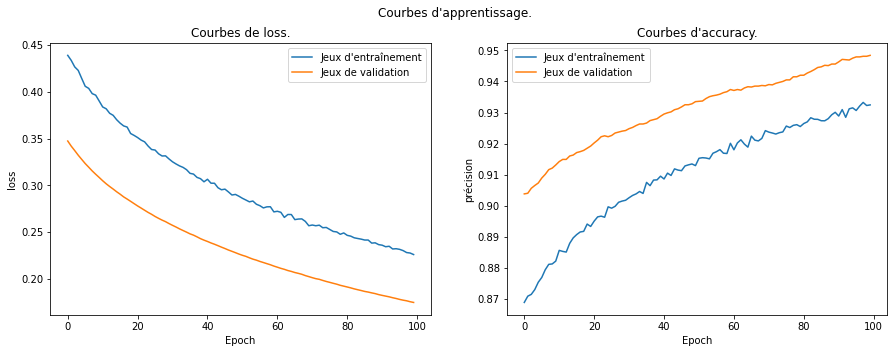

In [19]:
import matplotlib.pyplot as plt

debut= 0
x= [x for x in range(len(hist3.history["loss"]))]

fig, axes= plt.subplots(1, 2, figsize= (15,5))
fig.suptitle("Courbes d'apprentissage.")
axes[0].plot(x[debut:], hist3.history["loss"][debut:], label="Jeux d'entraînement")
axes[0].plot(x[debut:],hist3.history["val_loss"][debut:], label="Jeux de validation")
axes[0].set_title("Courbes de loss.")
axes[0].set(xlabel= "Epoch", ylabel="loss")
axes[0].legend()

axes[1].plot(x[debut:],hist3.history["accuracy"][debut:], label="Jeux d'entraînement")
axes[1].plot(x[debut:],hist3.history["val_accuracy"][debut:], label="Jeux de validation")
axes[1].set_title("Courbes d'accuracy.")
axes[1].set(xlabel= "Epoch", ylabel="précision")
_= axes[1].legend()

In [2]:
d={'loss': [22.571229934692383,
  10.335871696472168,
  6.109948635101318,
  4.1272125244140625,
  3.1016037464141846,
  2.4336371421813965,
  2.041743278503418,
  1.7853261232376099,
  1.6038233041763306,
  1.458308219909668,
  1.3760160207748413,
  1.2875343561172485,
  1.2264832258224487,
  1.1609575748443604,
  1.121896743774414,
  1.0787242650985718,
  1.0318491458892822,
  0.9977041482925415,
  0.9545130133628845,
  0.9364075660705566,
  0.8979724049568176,
  0.8775693774223328,
  0.8555898666381836,
  0.8221238255500793,
  0.8000975847244263,
  0.7885547280311584,
  0.7681276202201843,
  0.7530555129051208,
  0.7319848537445068,
  0.7208031415939331,
  0.7034688591957092,
  0.6904558539390564,
  0.6759500503540039,
  0.6622772812843323,
  0.6488083600997925,
  0.6314892172813416,
  0.6228706240653992,
  0.6187745332717896,
  0.5985718369483948,
  0.5916908979415894,
  0.5722251534461975,
  0.580276608467102,
  0.5594924092292786,
  0.555302083492279,
  0.5417608022689819,
  0.5354365706443787,
  0.523945152759552,
  0.519014835357666,
  0.5158577561378479,
  0.4992319643497467,
  0.4984670579433441,
  0.4874868392944336,
  0.4824014902114868,
  0.4747413396835327,
  0.47210371494293213,
  0.4600667953491211,
  0.4546281397342682,
  0.44230836629867554,
  0.4515077769756317,
  0.44907838106155396,
  0.43689295649528503,
  0.4338133931159973,
  0.4160824418067932,
  0.42480432987213135,
  0.4172985553741455,
  0.40939339995384216,
  0.40631940960884094,
  0.39994436502456665,
  0.3923366069793701,
  0.3902750611305237,
  0.3859991133213043,
  0.3875753581523895,
  0.37908703088760376,
  0.37722721695899963,
  0.3759789764881134,
  0.3657592833042145,
  0.3627775013446808,
  0.3617583215236664,
  0.3536018133163452,
  0.3550317585468292,
  0.34497272968292236,
  0.3405953049659729,
  0.34537187218666077,
  0.3392258286476135,
  0.3393239378929138,
  0.33574652671813965,
  0.3273515999317169,
  0.32560503482818604,
  0.3220316767692566,
  0.3208162188529968,
  0.3173814117908478,
  0.31309974193573,
  0.3119923770427704,
  0.3120967745780945,
  0.3102223873138428,
  0.3036940097808838,
  0.30120325088500977,
  0.30065223574638367,
  0.298307329416275,
  0.295396625995636,
  0.29126542806625366,
  0.2908851206302643,
  0.2889742851257324,
  0.28735247254371643,
  0.28434428572654724,
  0.2763824462890625,
  0.2790781259536743,
  0.2759306728839874,
  0.2721720337867737,
  0.2753470242023468,
  0.27135398983955383,
  0.26709622144699097,
  0.26515883207321167,
  0.26399174332618713,
  0.2650022506713867,
  0.2581033706665039,
  0.26098665595054626,
  0.2582728862762451,
  0.26054856181144714,
  0.25188666582107544,
  0.2529369592666626,
  0.2511942684650421,
  0.2484438121318817,
  0.24308809638023376,
  0.24545450508594513,
  0.2492080181837082,
  0.2468338906764984,
  0.23913659155368805,
  0.23953895270824432,
  0.2367609441280365,
  0.2422270029783249,
  0.23594450950622559,
  0.23479217290878296,
  0.23172472417354584,
  0.22821305692195892,
  0.22727654874324799,
  0.22396329045295715,
  0.22607867419719696,
  0.2236178070306778,
  0.22751115262508392,
  0.22147159278392792,
  0.21871577203273773,
  0.2227349430322647,
  0.2192428708076477,
  0.21826471388339996,
  0.21498441696166992,
  0.21339920163154602,
  0.21217504143714905,
  0.2123773992061615,
  0.2115698903799057,
  0.21043212711811066,
  0.20961105823516846,
  0.20906615257263184,
  0.2039128690958023,
  0.20526400208473206,
  0.20645500719547272,
  0.20263008773326874,
  0.19836729764938354,
  0.1989881992340088,
  0.20229390263557434,
  0.20132537186145782,
  0.1982845813035965,
  0.19469791650772095,
  0.19626320898532867,
  0.196788489818573,
  0.19283917546272278,
  0.1970822960138321,
  0.18769556283950806,
  0.19411765038967133,
  0.19014285504817963,
  0.19087620079517365,
  0.18811053037643433,
  0.18524670600891113,
  0.1865449696779251,
  0.18232013285160065,
  0.18410730361938477,
  0.17757755517959595,
  0.18537765741348267,
  0.17992641031742096,
  0.1798526793718338,
  0.18243567645549774,
  0.17947164177894592,
  0.17801135778427124,
  0.17529979348182678,
  0.1756168156862259,
  0.17679807543754578,
  0.1763361692428589,
  0.17852026224136353,
  0.17050957679748535,
  0.16796477138996124,
  0.1714116483926773,
  0.17167720198631287,
  0.16723336279392242,
  0.16891609132289886,
  0.16874544322490692,
  0.16735504567623138,
  0.16677559912204742,
  0.16374513506889343,
  0.16801704466342926,
  0.16283190250396729,
  0.16497312486171722,
  0.16380763053894043,
  0.16186784207820892,
  0.16010025143623352,
  0.15797856450080872,
  0.16611401736736298,
  0.15758571028709412,
  0.15639418363571167,
  0.1588117927312851,
  0.15944801270961761,
  0.15445105731487274,
  0.15779000520706177,
  0.1550067812204361,
  0.15386302769184113,
  0.15753403306007385,
  0.15765541791915894,
  0.15355759859085083,
  0.15044479072093964,
  0.15291817486286163,
  0.1552068293094635,
  0.1487315148115158,
  0.15337781608104706,
  0.1497904360294342,
  0.1505456566810608,
  0.1533621847629547,
  0.1531863808631897,
  0.1495659202337265,
  0.14895060658454895,
  0.14714747667312622,
  0.1471671164035797,
  0.148018941283226,
  0.14718399941921234,
  0.1448180228471756,
  0.14542318880558014,
  0.14796355366706848,
  0.1468690037727356,
  0.14289595186710358,
  0.14092375338077545,
  0.1412864327430725,
  0.14173370599746704,
  0.14008599519729614,
  0.14077959954738617,
  0.13930021226406097,
  0.13948489725589752,
  0.14315178990364075,
  0.13522018492221832,
  0.13667328655719757,
  0.13636359572410583,
  0.13732314109802246,
  0.13888046145439148],
 'accuracy': [0.17578333616256714,
  0.34564998745918274,
  0.45855000615119934,
  0.5215666890144348,
  0.5545499920845032,
  0.5786833167076111,
  0.5866833329200745,
  0.5913000106811523,
  0.604533314704895,
  0.614383339881897,
  0.6303166747093201,
  0.6432666778564453,
  0.6559833288192749,
  0.6691333055496216,
  0.6802499890327454,
  0.6917499899864197,
  0.7032166719436646,
  0.7111499905586243,
  0.7249333262443542,
  0.7304499745368958,
  0.7404999732971191,
  0.7483500242233276,
  0.7539666891098022,
  0.7615333199501038,
  0.7699000239372253,
  0.7752500176429749,
  0.7796833515167236,
  0.7840333580970764,
  0.7902666926383972,
  0.7928666472434998,
  0.798383355140686,
  0.8014833331108093,
  0.8052166700363159,
  0.8120166659355164,
  0.8148166537284851,
  0.8197833299636841,
  0.8204666376113892,
  0.8238000273704529,
  0.8289333581924438,
  0.8317166566848755,
  0.8352000117301941,
  0.8339999914169312,
  0.8393666744232178,
  0.8429333567619324,
  0.8451333045959473,
  0.8460333347320557,
  0.8509666919708252,
  0.851016640663147,
  0.8532666563987732,
  0.8566499948501587,
  0.8590666651725769,
  0.8612499833106995,
  0.8631666898727417,
  0.8641666769981384,
  0.8648999929428101,
  0.8692833185195923,
  0.8701833486557007,
  0.8729333281517029,
  0.8705000281333923,
  0.8737833499908447,
  0.8745333552360535,
  0.8780166506767273,
  0.8810666799545288,
  0.8785333037376404,
  0.8825666904449463,
  0.8830999732017517,
  0.883983314037323,
  0.8858333230018616,
  0.8863833546638489,
  0.8888000249862671,
  0.8902333378791809,
  0.8896166682243347,
  0.8920666575431824,
  0.892549991607666,
  0.8931333422660828,
  0.895466685295105,
  0.8954166769981384,
  0.8968166708946228,
  0.8982666730880737,
  0.8974499702453613,
  0.9002833366394043,
  0.9020500183105469,
  0.9013166427612305,
  0.9020833373069763,
  0.9035833477973938,
  0.9051333069801331,
  0.9064833521842957,
  0.9064499735832214,
  0.9078166484832764,
  0.9077666401863098,
  0.9082499742507935,
  0.9104833602905273,
  0.909766674041748,
  0.9115333557128906,
  0.9105833172798157,
  0.9136833548545837,
  0.9139999747276306,
  0.9135500192642212,
  0.9156666398048401,
  0.9155499935150146,
  0.9156500101089478,
  0.9168499708175659,
  0.9179166555404663,
  0.9185500144958496,
  0.9195333123207092,
  0.9198333621025085,
  0.9199333190917969,
  0.9215333461761475,
  0.9213333129882812,
  0.921833336353302,
  0.9229666590690613,
  0.9235000014305115,
  0.923966646194458,
  0.9246000051498413,
  0.9237666726112366,
  0.9267666935920715,
  0.9251499772071838,
  0.9252333045005798,
  0.9261999726295471,
  0.9268166422843933,
  0.9269833564758301,
  0.928933322429657,
  0.9292333126068115,
  0.9301499724388123,
  0.9290500283241272,
  0.9282666444778442,
  0.9295166730880737,
  0.9300833344459534,
  0.9310500025749207,
  0.9319833517074585,
  0.9312333464622498,
  0.9316499829292297,
  0.9332333207130432,
  0.933566689491272,
  0.9336666464805603,
  0.9349499940872192,
  0.9347833395004272,
  0.9348499774932861,
  0.9351500272750854,
  0.9347000122070312,
  0.9362499713897705,
  0.9362999796867371,
  0.9361500144004822,
  0.9374666810035706,
  0.9376166462898254,
  0.9378166794776917,
  0.9387333393096924,
  0.9380999803543091,
  0.939633309841156,
  0.9394500255584717,
  0.9395999908447266,
  0.9394999742507935,
  0.9394833445549011,
  0.9406999945640564,
  0.9411333203315735,
  0.9403833150863647,
  0.9417333602905273,
  0.9422666430473328,
  0.9426833391189575,
  0.941016674041748,
  0.9421666860580444,
  0.9421833157539368,
  0.9436666369438171,
  0.9429500102996826,
  0.9444833397865295,
  0.944350004196167,
  0.9429333209991455,
  0.9451833367347717,
  0.9433333277702332,
  0.9443833231925964,
  0.9452333450317383,
  0.9456499814987183,
  0.9464166760444641,
  0.9455666542053223,
  0.9461833238601685,
  0.9458833336830139,
  0.9477999806404114,
  0.9467999935150146,
  0.947516679763794,
  0.9475833177566528,
  0.9483000040054321,
  0.9476500153541565,
  0.9482499957084656,
  0.9493499994277954,
  0.9495333433151245,
  0.948366641998291,
  0.9492499828338623,
  0.948033332824707,
  0.9503999948501587,
  0.9506833553314209,
  0.9502500295639038,
  0.9502500295639038,
  0.9513833522796631,
  0.9509833455085754,
  0.9513499736785889,
  0.9506000280380249,
  0.9507833123207092,
  0.9522500038146973,
  0.9512166380882263,
  0.9524499773979187,
  0.9505000114440918,
  0.9518666863441467,
  0.9521166682243347,
  0.9528833627700806,
  0.9540166854858398,
  0.9520833492279053,
  0.9538333415985107,
  0.9542166590690613,
  0.9521999955177307,
  0.9537500143051147,
  0.9549499750137329,
  0.9536166787147522,
  0.9548500180244446,
  0.9561166763305664,
  0.9541500210762024,
  0.9550833106040955,
  0.9549000263214111,
  0.9561499953269958,
  0.9552000164985657,
  0.9550833106040955,
  0.9560999870300293,
  0.9559000134468079,
  0.9571999907493591,
  0.9561333060264587,
  0.9549333453178406,
  0.9555666446685791,
  0.9563666582107544,
  0.956683337688446,
  0.9567166566848755,
  0.9572499990463257,
  0.956083357334137,
  0.9580833315849304,
  0.957099974155426,
  0.9578499794006348,
  0.9573666453361511,
  0.9571166634559631,
  0.958133339881897,
  0.9581999778747559,
  0.9587833285331726,
  0.9584833383560181,
  0.9589333534240723,
  0.9578333497047424,
  0.9589999914169312,
  0.9594333171844482,
  0.9584333300590515,
  0.9598666429519653,
  0.9599499702453613,
  0.9598166942596436,
  0.9598833322525024,
  0.9592333436012268],
 'val_loss': [3.031341314315796,
  1.5699903964996338,
  1.0497677326202393,
  0.7776825428009033,
  0.6439451575279236,
  0.6056201457977295,
  0.6140367984771729,
  0.6350357532501221,
  0.6557522416114807,
  0.6547847390174866,
  0.6481831073760986,
  0.6264583468437195,
  0.6074733138084412,
  0.579046368598938,
  0.553992748260498,
  0.529743492603302,
  0.5051908493041992,
  0.4870063066482544,
  0.4659081995487213,
  0.4488614797592163,
  0.42676079273223877,
  0.4111696779727936,
  0.3950824439525604,
  0.38081082701683044,
  0.3665113151073456,
  0.3582788407802582,
  0.3464433252811432,
  0.3384303152561188,
  0.3304852843284607,
  0.3197755515575409,
  0.3119647800922394,
  0.3054560422897339,
  0.2980692982673645,
  0.29203084111213684,
  0.2845522165298462,
  0.27637308835983276,
  0.26948094367980957,
  0.2657376825809479,
  0.25997260212898254,
  0.2543179988861084,
  0.2505413591861725,
  0.24574440717697144,
  0.2408403605222702,
  0.2363845705986023,
  0.23154672980308533,
  0.2278728485107422,
  0.22292949259281158,
  0.21943798661231995,
  0.21661514043807983,
  0.21243813633918762,
  0.2081778347492218,
  0.20444804430007935,
  0.20085109770298004,
  0.19767050445079803,
  0.19493651390075684,
  0.19196482002735138,
  0.18806864321231842,
  0.1852509081363678,
  0.18288055062294006,
  0.18175843358039856,
  0.17855945229530334,
  0.1758742332458496,
  0.17315948009490967,
  0.17167021334171295,
  0.1697779893875122,
  0.1676325798034668,
  0.16541962325572968,
  0.16345477104187012,
  0.161615788936615,
  0.15938511490821838,
  0.15756450593471527,
  0.15535525977611542,
  0.15353776514530182,
  0.1520182341337204,
  0.1499948650598526,
  0.14813609421253204,
  0.14680637419223785,
  0.1449691355228424,
  0.14304989576339722,
  0.14179463684558868,
  0.14036481082439423,
  0.13872858881950378,
  0.13727016746997833,
  0.13587906956672668,
  0.13430863618850708,
  0.13323929905891418,
  0.13211265206336975,
  0.13078759610652924,
  0.12960490584373474,
  0.12813253700733185,
  0.12705162167549133,
  0.12598645687103271,
  0.12507428228855133,
  0.12387549132108688,
  0.12283327430486679,
  0.12178769707679749,
  0.12089131772518158,
  0.11983587592840195,
  0.11853891611099243,
  0.11754690110683441,
  0.1167646273970604,
  0.11573144793510437,
  0.11469423770904541,
  0.1134658232331276,
  0.11255492269992828,
  0.1117669939994812,
  0.11100040376186371,
  0.11028022319078445,
  0.10936801880598068,
  0.1081220805644989,
  0.10745365917682648,
  0.10687244683504105,
  0.10606618970632553,
  0.10532866418361664,
  0.10453664511442184,
  0.10381867736577988,
  0.1031174436211586,
  0.10204331576824188,
  0.10130175948143005,
  0.10066673904657364,
  0.09991008788347244,
  0.09938462823629379,
  0.09871770441532135,
  0.09806669503450394,
  0.09751610457897186,
  0.09701088815927505,
  0.09631764143705368,
  0.09572737663984299,
  0.09511946886777878,
  0.09466475993394852,
  0.09394030272960663,
  0.0934094563126564,
  0.09262581914663315,
  0.09214980155229568,
  0.0915430560708046,
  0.09110689908266068,
  0.0906534492969513,
  0.08999553322792053,
  0.08945480734109879,
  0.08898906409740448,
  0.08836733549833298,
  0.08781008422374725,
  0.08718053996562958,
  0.08675672113895416,
  0.08618535101413727,
  0.08581068366765976,
  0.08524076640605927,
  0.08486384153366089,
  0.08436303585767746,
  0.08389611542224884,
  0.08353693038225174,
  0.08322854340076447,
  0.08282335847616196,
  0.08223509043455124,
  0.08178862929344177,
  0.08149821311235428,
  0.08109918981790543,
  0.08077280968427658,
  0.08040028810501099,
  0.08007082343101501,
  0.07974860072135925,
  0.07947584986686707,
  0.0791444182395935,
  0.07856368273496628,
  0.07811081409454346,
  0.0775468498468399,
  0.07717055082321167,
  0.07695940881967545,
  0.07665159553289413,
  0.07623490691184998,
  0.07584399729967117,
  0.07555040717124939,
  0.07503439486026764,
  0.07477319985628128,
  0.07428228855133057,
  0.07390613108873367,
  0.07362920790910721,
  0.07329487055540085,
  0.07312452793121338,
  0.0728532075881958,
  0.07247147709131241,
  0.07206699997186661,
  0.07176759093999863,
  0.07142528891563416,
  0.07123075425624847,
  0.07082061469554901,
  0.07051169127225876,
  0.07029270380735397,
  0.06980574876070023,
  0.06962636858224869,
  0.06952233612537384,
  0.06928159296512604,
  0.06915459036827087,
  0.06873907893896103,
  0.06841115653514862,
  0.0682339072227478,
  0.06809186190366745,
  0.06769560277462006,
  0.06734767556190491,
  0.06719991564750671,
  0.06705415993928909,
  0.06683734804391861,
  0.06652384996414185,
  0.06619293987751007,
  0.06590990722179413,
  0.0657239779829979,
  0.06532961130142212,
  0.06523773074150085,
  0.06495457887649536,
  0.06477101147174835,
  0.06468566507101059,
  0.06446430087089539,
  0.06425376236438751,
  0.06409706920385361,
  0.06385045498609543,
  0.06362196803092957,
  0.06338892877101898,
  0.06304365396499634,
  0.06282585859298706,
  0.06266450881958008,
  0.06252395361661911,
  0.06228814646601677,
  0.062058936804533005,
  0.06196163222193718,
  0.06179120019078255,
  0.06163713335990906,
  0.06126817688345909,
  0.06101376190781593,
  0.060826610773801804,
  0.060617804527282715,
  0.06048405170440674,
  0.060302238911390305,
  0.060186609625816345,
  0.06011736020445824,
  0.05989125370979309,
  0.059747520834207535,
  0.059465229511260986,
  0.0593511126935482,
  0.059119854122400284,
  0.059014324098825455,
  0.0587654784321785,
  0.058509185910224915,
  0.05839913338422775,
  0.0582449696958065,
  0.05810728296637535,
  0.05798839032649994,
  0.057756517082452774,
  0.05757756903767586,
  0.057356707751750946,
  0.05704180896282196],
 'val_accuracy': [0.5719000101089478,
  0.7361999750137329,
  0.7853999733924866,
  0.8057000041007996,
  0.8147000074386597,
  0.8169000148773193,
  0.8159000277519226,
  0.8167999982833862,
  0.8169000148773193,
  0.8216000199317932,
  0.8284000158309937,
  0.8367999792098999,
  0.8424000144004822,
  0.8515999913215637,
  0.857699990272522,
  0.8655999898910522,
  0.871999979019165,
  0.8770999908447266,
  0.883899986743927,
  0.8878999948501587,
  0.8924999833106995,
  0.8949999809265137,
  0.8988000154495239,
  0.9006999731063843,
  0.9057000279426575,
  0.9074000120162964,
  0.9103000164031982,
  0.9111999869346619,
  0.9136000275611877,
  0.9161999821662903,
  0.9182999730110168,
  0.9199000000953674,
  0.9225999712944031,
  0.923799991607666,
  0.9271000027656555,
  0.9286999702453613,
  0.9301000237464905,
  0.9307000041007996,
  0.9320999979972839,
  0.9347000122070312,
  0.9347000122070312,
  0.9351999759674072,
  0.9362000226974487,
  0.9387999773025513,
  0.9397000074386597,
  0.9408000111579895,
  0.941100001335144,
  0.9419999718666077,
  0.9427000284194946,
  0.9435999989509583,
  0.9449999928474426,
  0.9453999996185303,
  0.946399986743927,
  0.9470000267028809,
  0.9473999738693237,
  0.9480000138282776,
  0.9488000273704529,
  0.9498999714851379,
  0.9498999714851379,
  0.9514999985694885,
  0.9521999955177307,
  0.9527999758720398,
  0.9534000158309937,
  0.9545000195503235,
  0.9549999833106995,
  0.9557999968528748,
  0.9560999870300293,
  0.9556000232696533,
  0.9560999870300293,
  0.957099974155426,
  0.9577999711036682,
  0.9577999711036682,
  0.9584000110626221,
  0.958299994468689,
  0.9595999717712402,
  0.9596999883651733,
  0.9602000117301941,
  0.9606999754905701,
  0.9610999822616577,
  0.9613000154495239,
  0.9624000191688538,
  0.9620000123977661,
  0.9617000222206116,
  0.9625999927520752,
  0.9631999731063843,
  0.9629999995231628,
  0.9628999829292297,
  0.9634000062942505,
  0.9641000032424927,
  0.9642000198364258,
  0.9639000296592712,
  0.9642000198364258,
  0.9646999835968018,
  0.9646000266075134,
  0.9642999768257141,
  0.964900016784668,
  0.9653000235557556,
  0.9653000235557556,
  0.9659000039100647,
  0.9661999940872192,
  0.9666000008583069,
  0.9666000008583069,
  0.9668999910354614,
  0.9670000076293945,
  0.9675999879837036,
  0.9678999781608582,
  0.9681000113487244,
  0.9685999751091003,
  0.968999981880188,
  0.9693999886512756,
  0.9695000052452087,
  0.9697999954223633,
  0.9700000286102295,
  0.9703999757766724,
  0.9710000157356262,
  0.9710999727249146,
  0.9708999991416931,
  0.9717000126838684,
  0.9718000292778015,
  0.9717000126838684,
  0.972100019454956,
  0.972000002861023,
  0.9721999764442444,
  0.9721999764442444,
  0.9725000262260437,
  0.9728000164031982,
  0.9728000164031982,
  0.9728000164031982,
  0.9728999733924866,
  0.9731000065803528,
  0.9732999801635742,
  0.9731000065803528,
  0.9735999703407288,
  0.9739999771118164,
  0.9735999703407288,
  0.9736999869346619,
  0.9740999937057495,
  0.974399983882904,
  0.974399983882904,
  0.9743000268936157,
  0.9746999740600586,
  0.974399983882904,
  0.9745000004768372,
  0.9746000170707703,
  0.9745000004768372,
  0.9740999937057495,
  0.9746000170707703,
  0.9745000004768372,
  0.9746000170707703,
  0.9747999906539917,
  0.9751999974250793,
  0.9751999974250793,
  0.975600004196167,
  0.9750999808311462,
  0.9753000140190125,
  0.9753999710083008,
  0.9760000109672546,
  0.9761000275611877,
  0.9764000177383423,
  0.9760000109672546,
  0.9760000109672546,
  0.9757999777793884,
  0.9761999845504761,
  0.9761999845504761,
  0.9764999747276306,
  0.9764999747276306,
  0.9764999747276306,
  0.9768000245094299,
  0.9772999882698059,
  0.9771000146865845,
  0.9769999980926514,
  0.9771999716758728,
  0.9772999882698059,
  0.9775999784469604,
  0.9776999950408936,
  0.9775999784469604,
  0.9775999784469604,
  0.9776999950408936,
  0.9775999784469604,
  0.9779999852180481,
  0.9778000116348267,
  0.9779999852180481,
  0.9782000184059143,
  0.9782000184059143,
  0.9782999753952026,
  0.9782999753952026,
  0.9785000085830688,
  0.9786999821662903,
  0.9785000085830688,
  0.978600025177002,
  0.9789000153541565,
  0.9787999987602234,
  0.9789999723434448,
  0.9790999889373779,
  0.9790999889373779,
  0.979200005531311,
  0.9794999957084656,
  0.9796000123023987,
  0.9793999791145325,
  0.9797000288963318,
  0.9794999957084656,
  0.9797999858856201,
  0.9797999858856201,
  0.9799000024795532,
  0.9800000190734863,
  0.9801999926567078,
  0.9801999926567078,
  0.9803000092506409,
  0.9801999926567078,
  0.9804999828338623,
  0.980400025844574,
  0.9805999994277954,
  0.9807999730110168,
  0.9803000092506409,
  0.9803000092506409,
  0.9803000092506409,
  0.9805999994277954,
  0.9804999828338623,
  0.9807999730110168,
  0.9807000160217285,
  0.9807999730110168,
  0.9807999730110168,
  0.9811000227928162,
  0.98089998960495,
  0.9810000061988831,
  0.9810000061988831,
  0.9810000061988831,
  0.9811000227928162,
  0.9812999963760376,
  0.9810000061988831,
  0.9811000227928162,
  0.9811999797821045,
  0.9811999797821045,
  0.9814000129699707,
  0.9815000295639038,
  0.9814000129699707,
  0.9817000031471252,
  0.9817000031471252,
  0.9817000031471252,
  0.9819999933242798,
  0.9818000197410583,
  0.9817000031471252,
  0.9821000099182129,
  0.9819999933242798,
  0.9818000197410583,
  0.9819999933242798,
  0.9817000031471252,
  0.9821000099182129,
  0.982200026512146,
  0.9825000166893005]}



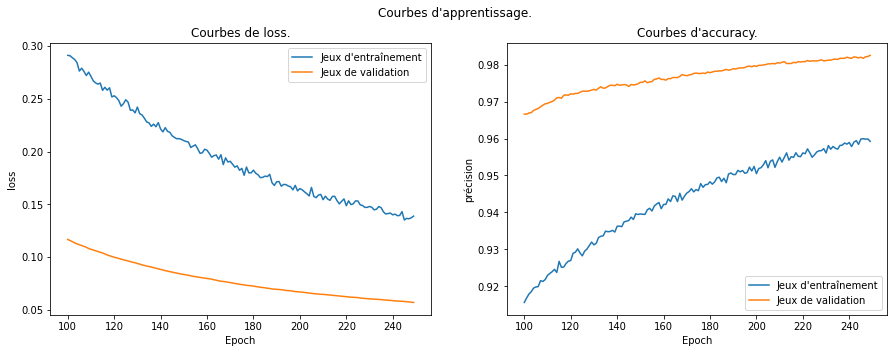

In [6]:
x= range(len(d["loss"]))

fig, axes= plt.subplots(1, 2, figsize= (15,5))
fig.suptitle("Courbes d'apprentissage.")
axes[0].plot(x[100:], d["loss"][100:], label="Jeux d'entraînement")
axes[0].plot(x[100:],d["val_loss"][100:], label="Jeux de validation")
axes[0].set_title("Courbes de loss.")
axes[0].set(xlabel= "Epoch", ylabel="loss")
axes[0].legend()

axes[1].plot(x[100:],d["accuracy"][100:], label="Jeux d'entraînement")
axes[1].plot(x[100:],d["val_accuracy"][100:], label="Jeux de validation")
axes[1].set_title("Courbes d'accuracy.")
axes[1].set(xlabel= "Epoch", ylabel="précision")
_= axes[1].legend()

In [3]:
# Importation du jeux d'entraînement
f = h5py.File("./datas/train.hdf5", 'r')
train_x, train_y = (f['image'][...])/255.0, f['label'][...]
f.close()

# Importation du jeux de test
f = h5py.File("./datas/test.hdf5", 'r')
test_x, test_y = (f['image'][...])/255.0, f['label'][...]
f.close()



In [4]:
# On récupère les données et on les met en forme pour qu'elles soient compatible avec le CNN.
# la dimension des données de test et de train sont de type:
#  (shape[0],shape[1], shape[2]), il sera nécessaire d'y ajouter une dimension supplémentaire
data_train_pour_cnn= train_x.reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2], 1)
data_test_pour_cnn= test_x.reshape(test_x.shape[0], test_x.shape[1], test_x.shape[2], 1)

etiquette= np.unique(test_y)

# convert class vectors to binary class matrices
train_y_conv = keras.utils.to_categorical(train_y, len(etiquette))
test_y_conv = keras.utils.to_categorical(test_y, len(etiquette))


print(f"Entrainement: X Shape: {data_train_pour_cnn.shape}, Y shape: {train_y.shape}\n"+\
      f"Test: X Shape: {data_test_pour_cnn.shape}, Y shape: {test_y.shape}\n"+\
      f"Etiquette: {etiquette}")

Entrainement: X Shape: (60000, 28, 28, 1), Y shape: (60000,)
Test: X Shape: (10000, 28, 28, 1), Y shape: (10000,)
Etiquette: [0 1 2 3 4 5 6 7 8 9]


In [5]:
batch_size = 128
epochs = 200

input_shape= (train_x.shape[1], train_x.shape[2], 1)
nb_classe= len(etiquette)

model2 = Sequential()

model2.add(Conv2D(16, kernel_size=(3, 3),activation='relu',input_shape= input_shape ))

model2.add(Conv2D(32, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))

model2.add(Conv2D(32, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten())

model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.3))

model2.add(Dense(nb_classe, activation='softmax'))
model2.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.Adadelta(),metrics=['accuracy'])

model2.summary()

2022-03-20 21:20:30.348334: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-20 21:20:30.348426: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-20 21:20:30.348491: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (debian-jpphi): /proc/driver/nvidia/version does not exist
2022-03-20 21:20:30.349461: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                    

In [ ]:
# résultats entrainement réseau

d= {'loss': [2.3061065673828125,
  2.2917771339416504,
  2.27614164352417,
  2.2590174674987793,
  2.238802671432495,
  2.21299409866333,
  2.1814160346984863,
  2.1400442123413086,
  2.085916042327881,
  2.018521547317505,
  1.9317365884780884,
  1.8286138772964478,
  1.7095668315887451,
  1.5812666416168213,
  1.4579883813858032,
  1.349447250366211,
  1.2536414861679077,
  1.175964117050171,
  1.106194257736206,
  1.0473577976226807,
  0.9999394416809082,
  0.9559064507484436,
  0.913645327091217,
  0.8772290349006653,
  0.8476569056510925,
  0.8197755217552185,
  0.7987787127494812,
  0.7691942453384399,
  0.7498995661735535,
  0.7258330583572388,
  0.7093181610107422,
  0.6944416761398315,
  0.678104817867279,
  0.6627307534217834,
  0.6464785933494568,
  0.6325347423553467,
  0.6198845505714417,
  0.6130788326263428,
  0.6004114151000977,
  0.5887990593910217,
  0.5774383544921875,
  0.5693775415420532,
  0.5581936240196228,
  0.5517973303794861,
  0.5398036241531372,
  0.5355350971221924,
  0.5277780890464783,
  0.5195514559745789,
  0.5094976425170898,
  0.5025555491447449,
  0.4979395270347595,
  0.49123308062553406,
  0.48797470331192017,
  0.4772401750087738,
  0.47407954931259155,
  0.463463693857193,
  0.4656029939651489,
  0.4577455520629883,
  0.45382988452911377,
  0.4464859068393707,
  0.4421406686306,
  0.4406331777572632,
  0.4330628514289856,
  0.4287244379520416,
  0.42397406697273254,
  0.42183050513267517,
  0.41795554757118225,
  0.41357070207595825,
  0.41012266278266907,
  0.4011857807636261,
  0.40308877825737,
  0.39866483211517334,
  0.39374247193336487,
  0.3921670913696289,
  0.38889098167419434,
  0.3865952491760254,
  0.3830573856830597,
  0.3788374066352844,
  0.37669360637664795,
  0.3754936158657074,
  0.3714437782764435,
  0.36627256870269775,
  0.3642052710056305,
  0.36268168687820435,
  0.35929781198501587,
  0.3564794659614563,
  0.3508963882923126,
  0.34973710775375366,
  0.350025475025177,
  0.34630027413368225,
  0.34454774856567383,
  0.3423616290092468,
  0.3378518521785736,
  0.33956506848335266,
  0.33524397015571594,
  0.33370405435562134,
  0.3296445906162262,
  0.32745057344436646,
  0.32661116123199463,
  0.3215690553188324,
  0.3205469846725464,
  0.3193848729133606,
  0.3190012276172638,
  0.31831347942352295,
  0.3147483766078949,
  0.313417911529541,
  0.30919960141181946,
  0.30597347021102905,
  0.3073131740093231,
  0.30509617924690247,
  0.3017425239086151,
  0.2999180853366852,
  0.3003510534763336,
  0.2961816191673279,
  0.2983556389808655,
  0.29403477907180786,
  0.2928611934185028,
  0.29086247086524963,
  0.2895987331867218,
  0.2895042896270752,
  0.28698378801345825,
  0.28461700677871704,
  0.28271588683128357,
  0.2808326482772827,
  0.2794552743434906,
  0.2806917130947113,
  0.27749699354171753,
  0.27690428495407104,
  0.2749274671077728,
  0.27243509888648987,
  0.2730196714401245,
  0.2693975865840912,
  0.2680327594280243,
  0.26561450958251953,
  0.2664223909378052,
  0.2652989327907562,
  0.26387232542037964,
  0.2638823091983795,
  0.2624863088130951,
  0.2583008110523224,
  0.2612965703010559,
  0.2575908899307251,
  0.25759634375572205,
  0.25336316227912903,
  0.2549549639225006,
  0.25242456793785095,
  0.2528214156627655,
  0.25080907344818115,
  0.2505547106266022,
  0.2491798996925354,
  0.24872800707817078,
  0.247191920876503,
  0.24618692696094513,
  0.24355222284793854,
  0.24188530445098877,
  0.24289947748184204,
  0.24127843976020813,
  0.23792438209056854,
  0.24015653133392334,
  0.23736850917339325,
  0.23798508942127228,
  0.23821651935577393,
  0.23436236381530762,
  0.23449259996414185,
  0.23150916397571564,
  0.2309296727180481,
  0.23016142845153809,
  0.23108859360218048,
  0.23100419342517853,
  0.22680051624774933,
  0.2268798053264618,
  0.22737276554107666,
  0.22499367594718933,
  0.2200794219970703,
  0.2251913994550705,
  0.22082948684692383,
  0.22280718386173248,
  0.21944746375083923,
  0.21782958507537842,
  0.22220176458358765,
  0.21713973581790924,
  0.217111274600029,
  0.21648629009723663,
  0.2166212499141693,
  0.21675105392932892,
  0.2143969088792801,
  0.2137438803911209,
  0.21278789639472961,
  0.21075187623500824,
  0.21140950918197632,
  0.21130411326885223,
  0.21129949390888214,
  0.2101021111011505,
  0.2105921357870102,
  0.2094162106513977,
  0.2095172256231308,
  0.2064632624387741,
  0.2056087702512741,
  0.20496441423892975,
  0.20644661784172058],
 'accuracy': [0.09925000369548798,
  0.13511666655540466,
  0.17866666615009308,
  0.2220333367586136,
  0.2706666588783264,
  0.31626665592193604,
  0.35753333568573,
  0.4010666608810425,
  0.4370500147342682,
  0.47494998574256897,
  0.5042666792869568,
  0.5325000286102295,
  0.5569666624069214,
  0.5787333250045776,
  0.5978833436965942,
  0.6161999702453613,
  0.6320499777793884,
  0.6456500291824341,
  0.6638500094413757,
  0.6786666512489319,
  0.6885333061218262,
  0.69964998960495,
  0.7115166783332825,
  0.7225833535194397,
  0.7334166765213013,
  0.7403333187103271,
  0.7465166449546814,
  0.7558000087738037,
  0.7611666917800903,
  0.7709333300590515,
  0.7778499722480774,
  0.7818666696548462,
  0.7871500253677368,
  0.7897499799728394,
  0.7958666682243347,
  0.8028666377067566,
  0.8053500056266785,
  0.8071666955947876,
  0.8099499940872192,
  0.8150666952133179,
  0.8176833391189575,
  0.8227166533470154,
  0.8250666856765747,
  0.8274999856948853,
  0.829633355140686,
  0.8323833346366882,
  0.8358166813850403,
  0.8387666940689087,
  0.840499997138977,
  0.8429999947547913,
  0.8446666598320007,
  0.8473666906356812,
  0.8483499884605408,
  0.852566659450531,
  0.852733314037323,
  0.8544666767120361,
  0.8557666540145874,
  0.8577499985694885,
  0.8589833378791809,
  0.8618000149726868,
  0.8629166483879089,
  0.8637833595275879,
  0.8657666444778442,
  0.8665000200271606,
  0.8689166903495789,
  0.8694333434104919,
  0.8712666630744934,
  0.8709333539009094,
  0.874833345413208,
  0.87663334608078,
  0.8752166628837585,
  0.8773999810218811,
  0.878250002861023,
  0.8788166642189026,
  0.8804166913032532,
  0.8798999786376953,
  0.8815000057220459,
  0.8839499950408936,
  0.8852166533470154,
  0.883650004863739,
  0.8851833343505859,
  0.8870333433151245,
  0.8874333500862122,
  0.8890833258628845,
  0.8886666893959045,
  0.8895166516304016,
  0.892799973487854,
  0.8912333250045776,
  0.891700029373169,
  0.8941166400909424,
  0.8939999938011169,
  0.8941500186920166,
  0.896049976348877,
  0.8952333331108093,
  0.8966000080108643,
  0.8975333571434021,
  0.8994166851043701,
  0.9001333117485046,
  0.8969833254814148,
  0.9010666608810425,
  0.9016666412353516,
  0.9033666849136353,
  0.9016166925430298,
  0.902483344078064,
  0.902899980545044,
  0.902816653251648,
  0.904783308506012,
  0.9061499834060669,
  0.9060166478157043,
  0.9068999886512756,
  0.9065333604812622,
  0.907966673374176,
  0.9099666476249695,
  0.9101999998092651,
  0.9075999855995178,
  0.9099166393280029,
  0.90993332862854,
  0.9111499786376953,
  0.9095500111579895,
  0.911899983882904,
  0.9124333262443542,
  0.911549985408783,
  0.9124833345413208,
  0.9141666889190674,
  0.9142000079154968,
  0.9141499996185303,
  0.9139000177383423,
  0.9148333072662354,
  0.914983332157135,
  0.916366696357727,
  0.914983332157135,
  0.9183499813079834,
  0.9187333583831787,
  0.9185333251953125,
  0.9186999797821045,
  0.9183666706085205,
  0.9200999736785889,
  0.9184333086013794,
  0.920116662979126,
  0.9203333258628845,
  0.9195666909217834,
  0.9200666546821594,
  0.9206666946411133,
  0.921833336353302,
  0.9213833212852478,
  0.9220333099365234,
  0.9223333597183228,
  0.9237666726112366,
  0.9230833053588867,
  0.9243500232696533,
  0.923550009727478,
  0.9242666959762573,
  0.9250666499137878,
  0.9250166416168213,
  0.9258000254631042,
  0.925433337688446,
  0.925266683101654,
  0.9274333119392395,
  0.9265666604042053,
  0.9278500080108643,
  0.9259333610534668,
  0.9270666837692261,
  0.9274500012397766,
  0.928433358669281,
  0.9292666912078857,
  0.9286999702453613,
  0.9293666481971741,
  0.9295666813850403,
  0.9293166399002075,
  0.9295666813850403,
  0.930483341217041,
  0.9296000003814697,
  0.9302499890327454,
  0.932116687297821,
  0.9302999973297119,
  0.9322166442871094,
  0.9315999746322632,
  0.931850016117096,
  0.9330833554267883,
  0.931850016117096,
  0.9318833351135254,
  0.9333999752998352,
  0.9336166381835938,
  0.93381667137146,
  0.9328166842460632,
  0.9341166615486145,
  0.9340333342552185,
  0.9348000288009644,
  0.9351166486740112,
  0.9345666766166687,
  0.934499979019165,
  0.9342666864395142,
  0.9348833560943604,
  0.9351166486740112,
  0.9345166683197021,
  0.9367833137512207,
  0.9360666871070862,
  0.9361166954040527,
  0.9371500015258789,
  0.9359999895095825],
 'val_loss': [2.2965805530548096,
  2.2827844619750977,
  2.2672781944274902,
  2.2489395141601562,
  2.226579427719116,
  2.1982526779174805,
  2.161715507507324,
  2.1140542030334473,
  2.0517470836639404,
  1.9717187881469727,
  1.8703396320343018,
  1.7478872537612915,
  1.608731985092163,
  1.4631774425506592,
  1.3243892192840576,
  1.2005587816238403,
  1.0950065851211548,
  1.0065758228302002,
  0.9325761795043945,
  0.8708673715591431,
  0.8172407150268555,
  0.7719764709472656,
  0.7328186631202698,
  0.6982024908065796,
  0.668346643447876,
  0.6420301198959351,
  0.6190105676651001,
  0.5977172255516052,
  0.5781023502349854,
  0.5594396591186523,
  0.5438039302825928,
  0.5283510684967041,
  0.5137830972671509,
  0.5011587142944336,
  0.48875731229782104,
  0.47740039229393005,
  0.466319739818573,
  0.456467866897583,
  0.446790486574173,
  0.4381040930747986,
  0.4292483925819397,
  0.42093104124069214,
  0.4131058156490326,
  0.40662020444869995,
  0.39941132068634033,
  0.3929045796394348,
  0.3868379294872284,
  0.38018181920051575,
  0.37446892261505127,
  0.368073433637619,
  0.36319464445114136,
  0.3574940264225006,
  0.3530366122722626,
  0.3476742208003998,
  0.3432965874671936,
  0.3382492959499359,
  0.33421093225479126,
  0.3300148844718933,
  0.3266463279724121,
  0.3226832449436188,
  0.31892091035842896,
  0.3155096471309662,
  0.3120138347148895,
  0.308282732963562,
  0.3048592209815979,
  0.30214038491249084,
  0.2984413802623749,
  0.29536548256874084,
  0.292657732963562,
  0.28940221667289734,
  0.286411851644516,
  0.2838575541973114,
  0.28084689378738403,
  0.27798375487327576,
  0.27548709511756897,
  0.2733227014541626,
  0.27107542753219604,
  0.2684454321861267,
  0.26617923378944397,
  0.26377829909324646,
  0.2611522078514099,
  0.25916212797164917,
  0.25668883323669434,
  0.2543959617614746,
  0.25251510739326477,
  0.25065019726753235,
  0.24825969338417053,
  0.24613402783870697,
  0.24442580342292786,
  0.24237799644470215,
  0.2407122254371643,
  0.23857468366622925,
  0.2369348406791687,
  0.23553799092769623,
  0.2333659678697586,
  0.2319694608449936,
  0.23020628094673157,
  0.22816230356693268,
  0.22695642709732056,
  0.22522573173046112,
  0.22313779592514038,
  0.22145184874534607,
  0.2198963314294815,
  0.21880888938903809,
  0.21697087585926056,
  0.21524997055530548,
  0.2140871286392212,
  0.21257834136486053,
  0.21097804605960846,
  0.2100682556629181,
  0.20887377858161926,
  0.20706528425216675,
  0.20581921935081482,
  0.20438691973686218,
  0.20352783799171448,
  0.2018754780292511,
  0.20060770213603973,
  0.19964489340782166,
  0.19863972067832947,
  0.19738434255123138,
  0.19586363434791565,
  0.1948637068271637,
  0.19344620406627655,
  0.1924745887517929,
  0.1908162534236908,
  0.18985803425312042,
  0.18896318972110748,
  0.18764077126979828,
  0.18685507774353027,
  0.1855817288160324,
  0.184221550822258,
  0.1833982616662979,
  0.18250547349452972,
  0.18126118183135986,
  0.18030528724193573,
  0.17939938604831696,
  0.17845569550991058,
  0.17701992392539978,
  0.1765458732843399,
  0.17545484006404877,
  0.1748877614736557,
  0.17406971752643585,
  0.17284740507602692,
  0.1716780811548233,
  0.17086417973041534,
  0.17042423784732819,
  0.16923071444034576,
  0.16831596195697784,
  0.16718342900276184,
  0.16651670634746552,
  0.16579273343086243,
  0.1650230586528778,
  0.16426293551921844,
  0.16341692209243774,
  0.1626254916191101,
  0.1616911143064499,
  0.16078728437423706,
  0.16034653782844543,
  0.1593618094921112,
  0.15860405564308167,
  0.15803365409374237,
  0.1571517288684845,
  0.15645690262317657,
  0.15545594692230225,
  0.1548868715763092,
  0.15424871444702148,
  0.1534770131111145,
  0.1530594378709793,
  0.15242800116539001,
  0.1517319232225418,
  0.15083475410938263,
  0.15042172372341156,
  0.14972642064094543,
  0.1490679532289505,
  0.14847871661186218,
  0.14794008433818817,
  0.14683426916599274,
  0.14614756405353546,
  0.1456320583820343,
  0.14525263011455536,
  0.14443697035312653,
  0.14384733140468597,
  0.14315801858901978,
  0.14247499406337738,
  0.14208336174488068,
  0.14162138104438782,
  0.14085398614406586,
  0.14064925909042358,
  0.13962005078792572,
  0.13925813138484955,
  0.1385861337184906,
  0.1378072202205658,
  0.13760705292224884,
  0.13734540343284607,
  0.13654746115207672,
  0.1359088271856308,
  0.13533537089824677,
  0.1347668617963791,
  0.13424037396907806,
  0.13369861245155334],
 'val_accuracy': [0.10480000078678131,
  0.19449999928474426,
  0.29679998755455017,
  0.3714999854564667,
  0.4426000118255615,
  0.5128999948501587,
  0.5720000267028809,
  0.6169999837875366,
  0.6499999761581421,
  0.6777999997138977,
  0.70169997215271,
  0.722599983215332,
  0.7444000244140625,
  0.7554000020027161,
  0.7674000263214111,
  0.7788000106811523,
  0.7876999974250793,
  0.7979000210762024,
  0.8069000244140625,
  0.8133000135421753,
  0.8234000205993652,
  0.828499972820282,
  0.8338000178337097,
  0.8400999903678894,
  0.8443999886512756,
  0.8482000231742859,
  0.8518999814987183,
  0.8560000061988831,
  0.8593000173568726,
  0.8607000112533569,
  0.8647000193595886,
  0.8658999800682068,
  0.8687999844551086,
  0.8709999918937683,
  0.8730999827384949,
  0.8756999969482422,
  0.8779000043869019,
  0.8812000155448914,
  0.8833000063896179,
  0.8855999708175659,
  0.8877999782562256,
  0.8895000219345093,
  0.8902999758720398,
  0.8907999992370605,
  0.892300009727478,
  0.8938000202178955,
  0.8956999778747559,
  0.8978999853134155,
  0.8991000056266785,
  0.9002000093460083,
  0.9013000130653381,
  0.9035000205039978,
  0.9039999842643738,
  0.9057000279426575,
  0.9063000082969666,
  0.9075000286102295,
  0.9083999991416931,
  0.909600019454956,
  0.9093999862670898,
  0.9107000231742859,
  0.9110999703407288,
  0.9121000170707703,
  0.9124000072479248,
  0.9139999747276306,
  0.9140999913215637,
  0.9150999784469604,
  0.9168000221252441,
  0.9174000024795532,
  0.9180999994277954,
  0.9185000061988831,
  0.9193000197410583,
  0.9192000031471252,
  0.9211000204086304,
  0.9222999811172485,
  0.9222999811172485,
  0.92330002784729,
  0.92330002784729,
  0.9243000149726868,
  0.9244999885559082,
  0.9251999855041504,
  0.9262999892234802,
  0.926800012588501,
  0.9269999861717224,
  0.9280999898910522,
  0.9279999732971191,
  0.9290000200271606,
  0.9297000169754028,
  0.9302999973297119,
  0.9304999709129333,
  0.9305999875068665,
  0.9311000108718872,
  0.9318000078201294,
  0.9319000244140625,
  0.9322999715805054,
  0.9325000047683716,
  0.9332000017166138,
  0.9340000152587891,
  0.933899998664856,
  0.9350000023841858,
  0.9348999857902527,
  0.9352999925613403,
  0.935699999332428,
  0.9361000061035156,
  0.9366999864578247,
  0.9369000196456909,
  0.9370999932289124,
  0.9376000165939331,
  0.9379000067710876,
  0.9383999705314636,
  0.9398000240325928,
  0.9397000074386597,
  0.9398000240325928,
  0.9405999779701233,
  0.9406999945640564,
  0.9415000081062317,
  0.941100001335144,
  0.9419000148773193,
  0.9416000247001648,
  0.9419000148773193,
  0.9424999952316284,
  0.9430000185966492,
  0.9430999755859375,
  0.9440000057220459,
  0.944100022315979,
  0.9452999830245972,
  0.9452999830245972,
  0.9455999732017517,
  0.946399986743927,
  0.9459999799728394,
  0.9469000101089478,
  0.9466999769210815,
  0.9465000033378601,
  0.9466999769210815,
  0.9473000168800354,
  0.9470999836921692,
  0.9473000168800354,
  0.9473000168800354,
  0.9480000138282776,
  0.9483000040054321,
  0.948199987411499,
  0.9484999775886536,
  0.9484999775886536,
  0.9487000107765198,
  0.9495000243186951,
  0.9491999745368958,
  0.9495999813079834,
  0.9491999745368958,
  0.9498000144958496,
  0.9495000243186951,
  0.9498999714851379,
  0.9502000212669373,
  0.9508000016212463,
  0.9513000249862671,
  0.9509000182151794,
  0.9509999752044678,
  0.9514999985694885,
  0.9513000249862671,
  0.9519000053405762,
  0.9523000121116638,
  0.9523000121116638,
  0.9524999856948853,
  0.9532999992370605,
  0.9527000188827515,
  0.9531000256538391,
  0.9532999992370605,
  0.953499972820282,
  0.9538000226020813,
  0.954200029373169,
  0.9545000195503235,
  0.9539999961853027,
  0.9545000195503235,
  0.9546999931335449,
  0.9550999999046326,
  0.955299973487854,
  0.9556000232696533,
  0.955299973487854,
  0.9559999704360962,
  0.9557999968528748,
  0.9562000036239624,
  0.9560999870300293,
  0.95660001039505,
  0.9569000005722046,
  0.9571999907493591,
  0.9577000141143799,
  0.9575999975204468,
  0.9577000141143799,
  0.9580000042915344,
  0.9584000110626221,
  0.9581000208854675,
  0.9585999846458435,
  0.9587000012397766,
  0.9588000178337097,
  0.9585999846458435,
  0.9587000012397766,
  0.958899974822998,
  0.9589999914169312,
  0.9592000246047974,
  0.9591000080108643,
  0.9595999717712402,
  0.9596999883651733]}